# Benchmarking Kernels

The aim of this notebook is to benchmark different graph kernels

## Setup

### Change Working Directory

In [16]:
# Change working directory to the parent of the parent of the script

import os

# Get the current working directory
current_directory = os.getcwd()

# Get the parent of the parent directory
parent_parent_directory = os.path.abspath(os.path.join(current_directory, '..', '..'))

# Change the working directory to the parent of the parent directory
os.chdir(parent_parent_directory)

# Verify the change by printing the new working directory
print("New working directory:", os.getcwd())

New working directory: /vol/bitbucket


### Imports

In [17]:
import networkx as nx
import warnings
from typing import List
warnings.filterwarnings("ignore") # Turn off Graphein warnings
import torch
import gpytorch
import numpy as np
from tqdm import tqdm
import graphein.molecule as gm
from matplotlib import pyplot as plt
from botorch import fit_gpytorch_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gauche.dataloader import MolPropLoader
from gauche.dataloader.data_utils import transform_data
from gauche import SIGP, NonTensorialInputs
from modules.surrogate_models.kernel import ( 
    VertexHistogramKernel, EdgeHistogramKernel,
    WeisfeilerLehmanKernel, NeighborhoodHashKernel,
    RandomWalkKernel, ShortestPathKernel,
    WeisfeilerLehmanOptimalAssignmentKernel
)
import seaborn as sns
import pandas as pd
%matplotlib inline

## Gaussian Process Model

In [18]:
# Subclass the SIGP call that allows us to use kernels over
# discrete inputs with GPyTorch and BoTorch machinery


class GraphGP(SIGP):
    def __init__(
        self,
        train_x: NonTensorialInputs,
        train_y: torch.Tensor,
        likelihood: gpytorch.likelihoods.Likelihood,
        kernel: gpytorch.kernels.Kernel,
        **kernel_kwargs,
    ):
        """
        A subclass of the SIGP class that allows us to use kernels over
        discrete inputs with GPyTorch and BoTorch machinery.

        Parameters:
        -----------
        train_x: NonTensorialInputs
            The training inputs for the model. These are graph objects.
        train_y: torch.Tensor
            The training labels for the model.
        likelihood: gpytorch.likelihoods.Likelihood
            The likelihood function for the model.
        kernel: gpytorch.kernels.Kernel
            The kernel function for the model.
        **kernel_kwargs:
            The keyword arguments for the kernel function.
        """

        super().__init__(train_x, train_y, likelihood)
        self.mean = gpytorch.means.ConstantMean()
        self.covariance = kernel(**kernel_kwargs)

    def forward(self, x):
        """
        A forward pass through the model.
        """
        mean = self.mean(torch.zeros(len(x), 1)).float()
        covariance = self.covariance(x)

        # because graph kernels operate over discrete inputs it is beneficial
        # to add some jitter for numerical stability
        jitter = max(covariance.diag().mean().detach().item() * 1e-4, 1e-4)
        covariance += torch.eye(len(x)) * jitter
        return gpytorch.distributions.MultivariateNormal(mean, covariance)

## MSE calculation

In [19]:
def claculate_MSE(X, y,kernel,test_set_size=0.2,**kernel_kwargs):

    """
    Calculate the Mean Squared Error (MSE) of Gaussian Process (GP) regression model.

    Args:
        X (numpy.ndarray): Input features.
        y (numpy.ndarray): Target values.
        kernel (gpytorch.kernels.Kernel): The kernel function for the GP model.
        test_set_size (float, optional): Proportion of the dataset to include in the test split. Default is 0.2.
        **kernel_kwargs: Additional keyword arguments to be passed to the kernel function.

    Returns:
        float: The Mean Squared Error (MSE) of the GP regression model.
    """

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_set_size, random_state=2
    )
    _, y_train, _, y_test, y_scaler = transform_data(
        np.zeros_like(y_train), y_train, np.zeros_like(y_test), y_test
    )

    X_train = NonTensorialInputs(X_train)
    X_test = NonTensorialInputs(X_test)
    y_train = torch.tensor(y_train).flatten().float()
    y_test = torch.tensor(y_test).flatten().float()

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GraphGP(X_train, y_train, likelihood, kernel, **kernel_kwargs)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    fit_gpytorch_model(mll)

    model.eval()
    likelihood.eval()
    f_pred = model(X_test)
    y_pred = f_pred.mean
    y_var = f_pred.variance

    y_pred = y_scaler.inverse_transform(y_pred.detach().unsqueeze(dim=1))
    y_test = y_scaler.inverse_transform(y_test.detach().unsqueeze(dim=1))

    MSE = mean_squared_error(y_pred, y_test)

    return MSE, y_pred, y_test

## Benchmarking Class

In [20]:
class Benchmarks:
    """
    A class for benchmarking Gaussian Process (GP) regression models.

    Args:
        X (numpy.ndarray): Input features.
        Y (numpy.ndarray): Target values.
        kernels (list): List of kernel functions for GP models.
    """

    def __init__(self,X,Y,kernels):

        """
        Initializes the Benchmarks object.

        Args:
            X (numpy.ndarray): Input features.
            Y (numpy.ndarray): Target values.
            kernels (list): List of kernel functions for GP models.
        """
        self.X = X
        self.Y = Y
        self.kernels = kernels
        self.MSE_values = {}
        self.covariances = {}
        self.pred_test = {}

    def generate_MSE(self, split=0.2):
        """
        Generates Mean Squared Error (MSE) values for GP models using different kernels.

        Args:
            split (float, optional): Proportion of the dataset to include in the test split. Default is 0.2.
        """

        Y_2D = self.Y.reshape(-1,1)
        for kernel in self.kernels:
            print(kernel[0])
            try:
                if len(kernel) == 1:
                    MSE, pred, test = claculate_MSE(self.X,Y_2D,kernel[0],test_set_size=split)
                    name = kernel[0]().__class__.__name__
                elif len(kernel) == 2:
                    if "element" in kernel:
                        MSE, pred, test = claculate_MSE(self.X,Y_2D, kernel[0],test_set_size=split,node_label=kernel[1])
                        name = kernel[0](node_label=kernel[1]).__class__.__name__
                    else:
                        MSE, pred, test = claculate_MSE(self.X,Y_2D, kernel[0],test_set_size=split,edge_label=kernel[1])
                        name = kernel[0](edge_label=kernel[1]).__class__.__name__
                elif len(kernel) == 3:
                    MSE, pred, test = claculate_MSE(self.X,Y_2D, kernel[0],test_set_size=split,node_label=kernel[1], edge_label=kernel[2])
                    name = kernel[0](node_label=kernel[1], edge_label=kernel[2]).__class__.__name__

                if name == 'WeisfeilerLehmanOptimalAssignmentKernel':
                    name = 'WeisfeilerLehmanOA'
                else:
                    name = name[:-6]

                self.pred_test[name]=[pred,test]
                self.MSE_values[name] = MSE
            except:
                continue


    def plot_MSE(self):
        """
        Plots the MSE values.
        """
        kernels, mse_values = self.MSE_values.keys(), self.MSE_values.values()
        kernels = list(kernels)
        mse_values = list(mse_values)
        indicies = np.argsort(mse_values)
        kernels = np.array(kernels)[indicies]
        mse_values = sorted(mse_values)

        data = {
        'Category': kernels,
        'Value': mse_values
        }

        df = pd.DataFrame(data)
        sns.set_style()
        sns.barplot(x='Value', y='Category', data=df, orient='h', color='skyblue')
        plt.title('MSE vs Kernel Methods', fontsize=16, fontweight='bold')
        plt.xlabel('Mean Squared Error', fontsize=14)
        plt.ylabel('Kernel Method', fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=12)

        # Add a line for easier readability of each bar
        for index, value in enumerate(df['Value']):
            plt.text(value, index, f' {round(value,1)}', va='center', ha='left', fontsize=12)

        sns.despine(top=True, right=True)
        plt.xlim(0, max(df['Value']) * 1.1)
        plt.tight_layout()
        plt.show()

    def plot_GP(self):
        """
        Plots the predicted and actual test values for each GP model.
        """

        if not self.MSE_values:
            print('Need to generate MSE values first')
        else:
            n = len(self.pred_test)
            num_rows = (n + 2) // 3 
            fig1, axs1 = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows)) 


            cnt = 0
            for key, value in self.pred_test.items():


                row = cnt // 3
                col = cnt % 3

                axs1[row, col].plot(value[0], label='prediction') 
                axs1[row, col].plot(value[1], label='actual')
                axs1[row, col].set_title(key)
                axs1[row, col].set_xlabel('Graph Index')
                axs1[row, col].set_ylabel('Metric')
                axs1[row, col].legend()
                cnt += 1

            plt.tight_layout()
            plt.show()

    def plot_label_differences(self):
        """
        Plots the absolute difference label matrix.
        """

        y_arr = np.array(self.Y)
        y_arr = (y_arr - np.mean(y_arr))/np.std(y_arr)
        array1_col = np.array(y_arr).reshape(-1, 1)
        array2_col = np.array(y_arr).reshape(1, -1)
        abs_diff_matrix = np.abs(array1_col - array2_col)
        abs_diff_matrix = - abs_diff_matrix

        plt.imshow(abs_diff_matrix)
        plt.colorbar()
        plt.xlabel('Graph Index')
        plt.ylabel('Graph Index')
        plt.title('Negative Absolute difference label matrix')
        plt.show()

    def generate_covariances(self):
        """
        Generates covariance matrices for GP models using different kernels.
        """

        for kernel in self.kernels:
            print(kernel[0])
            try:
                if len(kernel) == 1:
                    value = kernel[0]()(NonTensorialInputs(self.X))
                    name = kernel[0]().__class__.__name__
                elif len(kernel) == 2:
                    if "element" in kernel:
                        value = kernel[0](node_label=kernel[1])(NonTensorialInputs(self.X))
                        name = kernel[0](node_label=kernel[1]).__class__.__name__
                    else:
                        value = kernel[0](edge_label=kernel[1])(NonTensorialInputs(self.X))
                        name = kernel[0](edge_label=kernel[1]).__class__.__name__
                elif len(kernel) == 3:
                    value = kernel[0](node_label=kernel[1], edge_label=kernel[2])(NonTensorialInputs(self.X))
                    name = kernel[0](node_label=kernel[1],edge_label=kernel[2]).__class__.__name__
            except:
                print('fitting error')
                continue
       
            self.covariances[name] = value

    def plot_covariances(self, standardise=True):
        """
        Plots the covariance matrices.

        Args:
            standardise (bool, optional): Whether to standardize the covariance matrices. Default is True.
        """

        if not self.covariances:
            print('Need to generate covariances first')
        else:
            
            n = len(self.covariances)                
            num_rows = (n + 2) // 3 
            fig1, axs1 = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
            
            cnt = 0
            for key, value in self.covariances.items():


                row = cnt // 3
                col = cnt % 3

                x = value.detach().numpy()

                if standardise:
                    x = (x-np.mean(x))/np.std(x)

                axs1[row, col].set_title(key)
                im = axs1[row, col].imshow(x,vmin=-3,vmax=3)
                axs1[row, col].set_xlabel('Graph Index')
                axs1[row, col].set_ylabel('Graph Index')
                axs1[row, col].legend()
                fig1.colorbar(im, ax=axs1[row,col])  
                cnt += 1

            plt.tight_layout()
            plt.show()

## Photoswitch Benchmarking

In [21]:
loader = MolPropLoader()
loader.load_benchmark("Photoswitch")
graphein_config = gm.MoleculeGraphConfig(
    node_metadata_functions=[gm.total_degree],
    edge_metadata_functions=[gm.add_bond_type])
loader.featurize("molecular_graphs", graphein_config=graphein_config)

Found 13 invalid labels [nan nan nan nan nan nan nan nan nan nan nan nan nan] at indices [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 158]
To turn validation off, use dataloader.read_csv(..., validate=False).


In [22]:
kernels = [[RandomWalkKernel],[VertexHistogramKernel,"element"],[NeighborhoodHashKernel, "element"],[ShortestPathKernel, "element"],[WeisfeilerLehmanOptimalAssignmentKernel,"element"],[WeisfeilerLehmanKernel,"element","bond"],[EdgeHistogramKernel,"bond"]]
X=loader.features
Y=loader.labels.reshape(-1)

In [23]:
benchmark = Benchmarks(X,Y,kernels)

<class 'modules.surrogate_models.kernel.RandomWalkKernel'>
<class 'modules.surrogate_models.kernel.VertexHistogramKernel'>
<class 'modules.surrogate_models.kernel.NeighborhoodHashKernel'>
<class 'modules.surrogate_models.kernel.ShortestPathKernel'>
<class 'modules.surrogate_models.kernel.WeisfeilerLehmanOptimalAssignmentKernel'>
<class 'modules.surrogate_models.kernel.WeisfeilerLehmanKernel'>
<class 'modules.surrogate_models.kernel.EdgeHistogramKernel'>


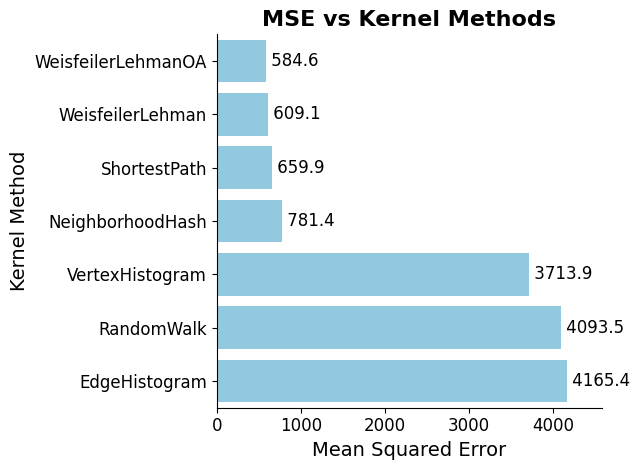

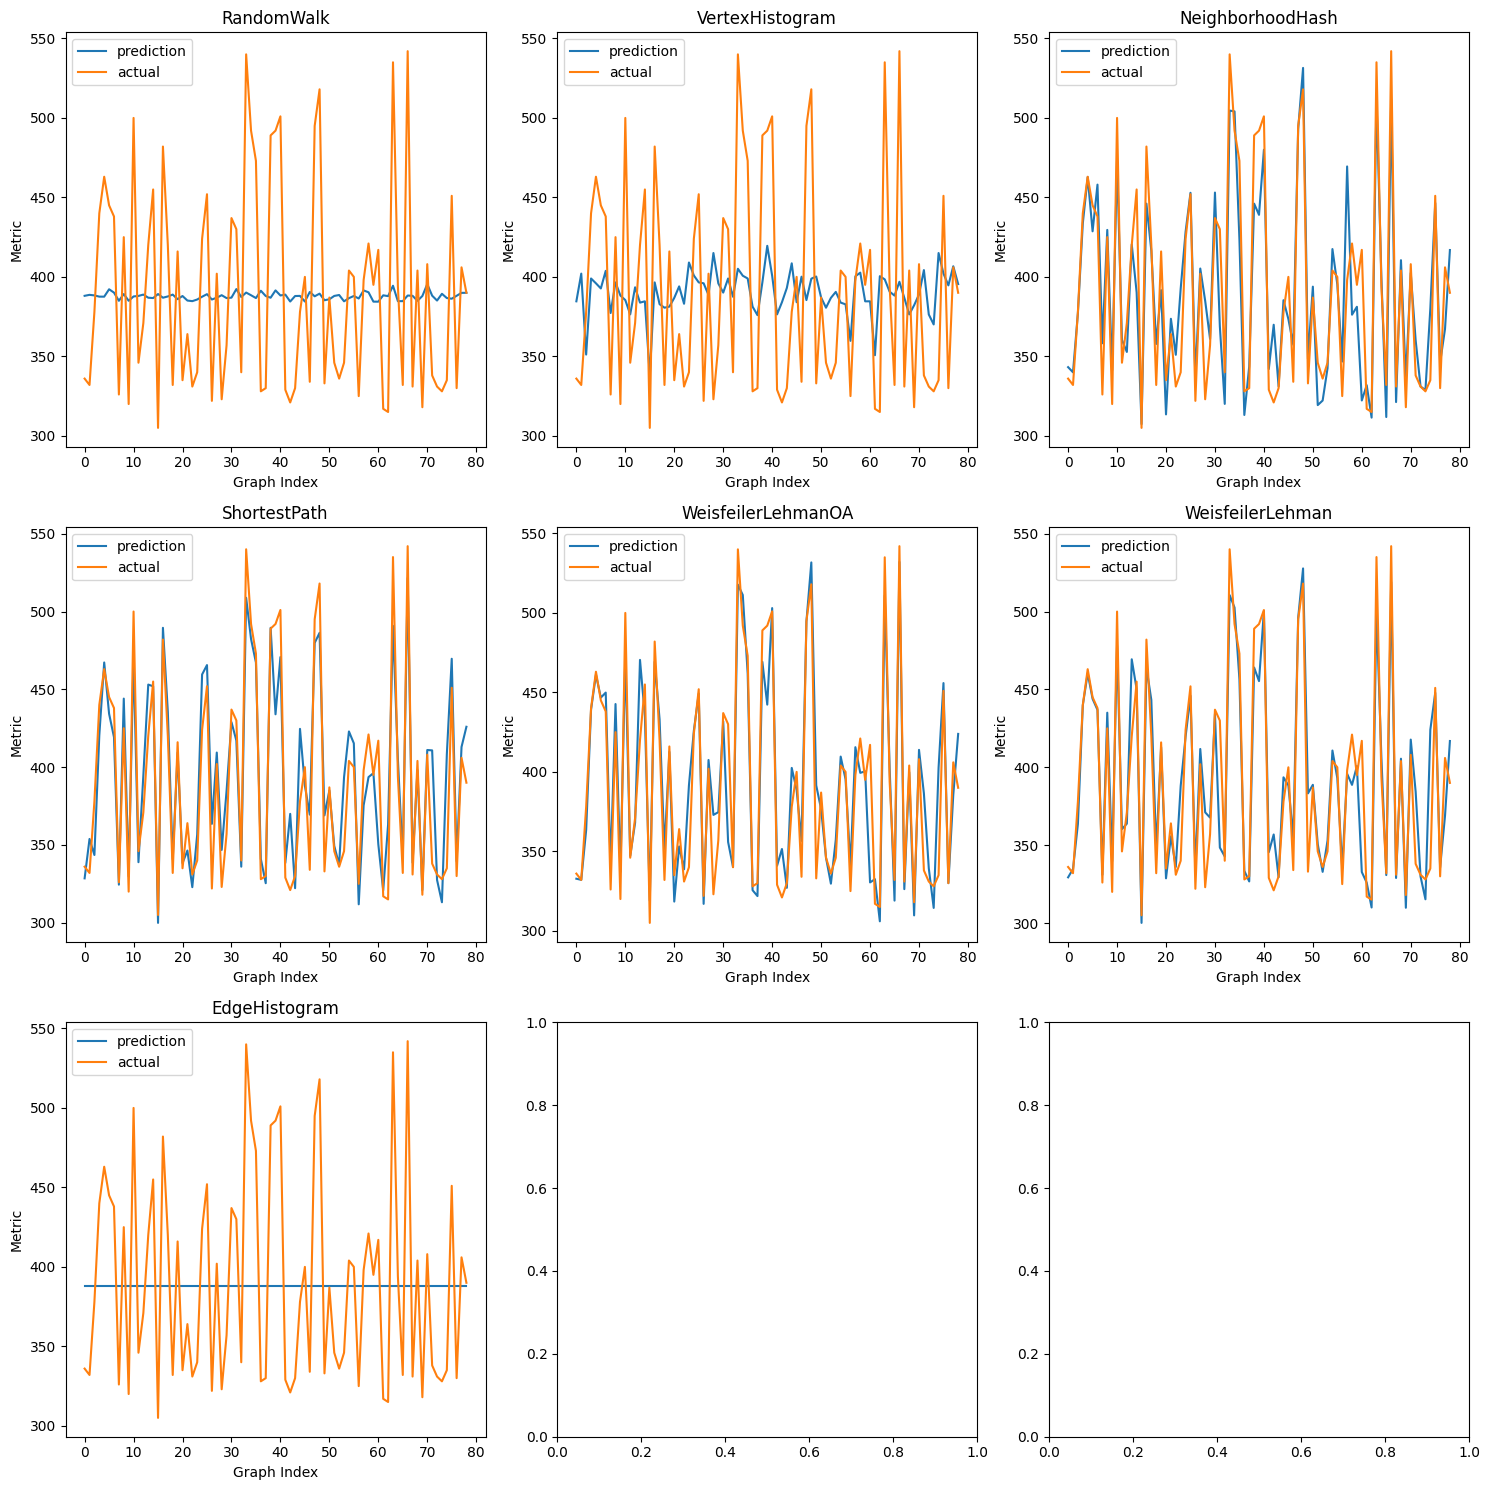

<class 'modules.surrogate_models.kernel.RandomWalkKernel'>
<class 'modules.surrogate_models.kernel.VertexHistogramKernel'>
<class 'modules.surrogate_models.kernel.NeighborhoodHashKernel'>
<class 'modules.surrogate_models.kernel.ShortestPathKernel'>
<class 'modules.surrogate_models.kernel.WeisfeilerLehmanOptimalAssignmentKernel'>
<class 'modules.surrogate_models.kernel.WeisfeilerLehmanKernel'>
<class 'modules.surrogate_models.kernel.EdgeHistogramKernel'>


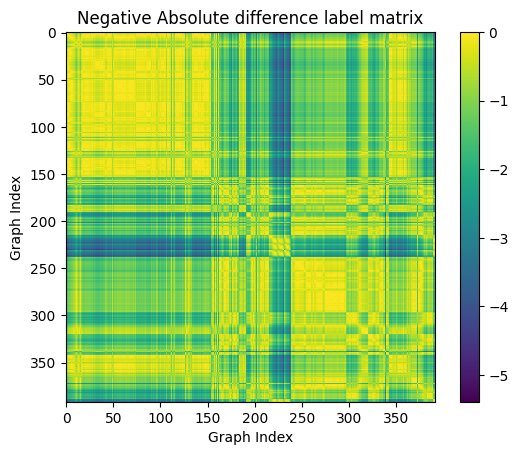

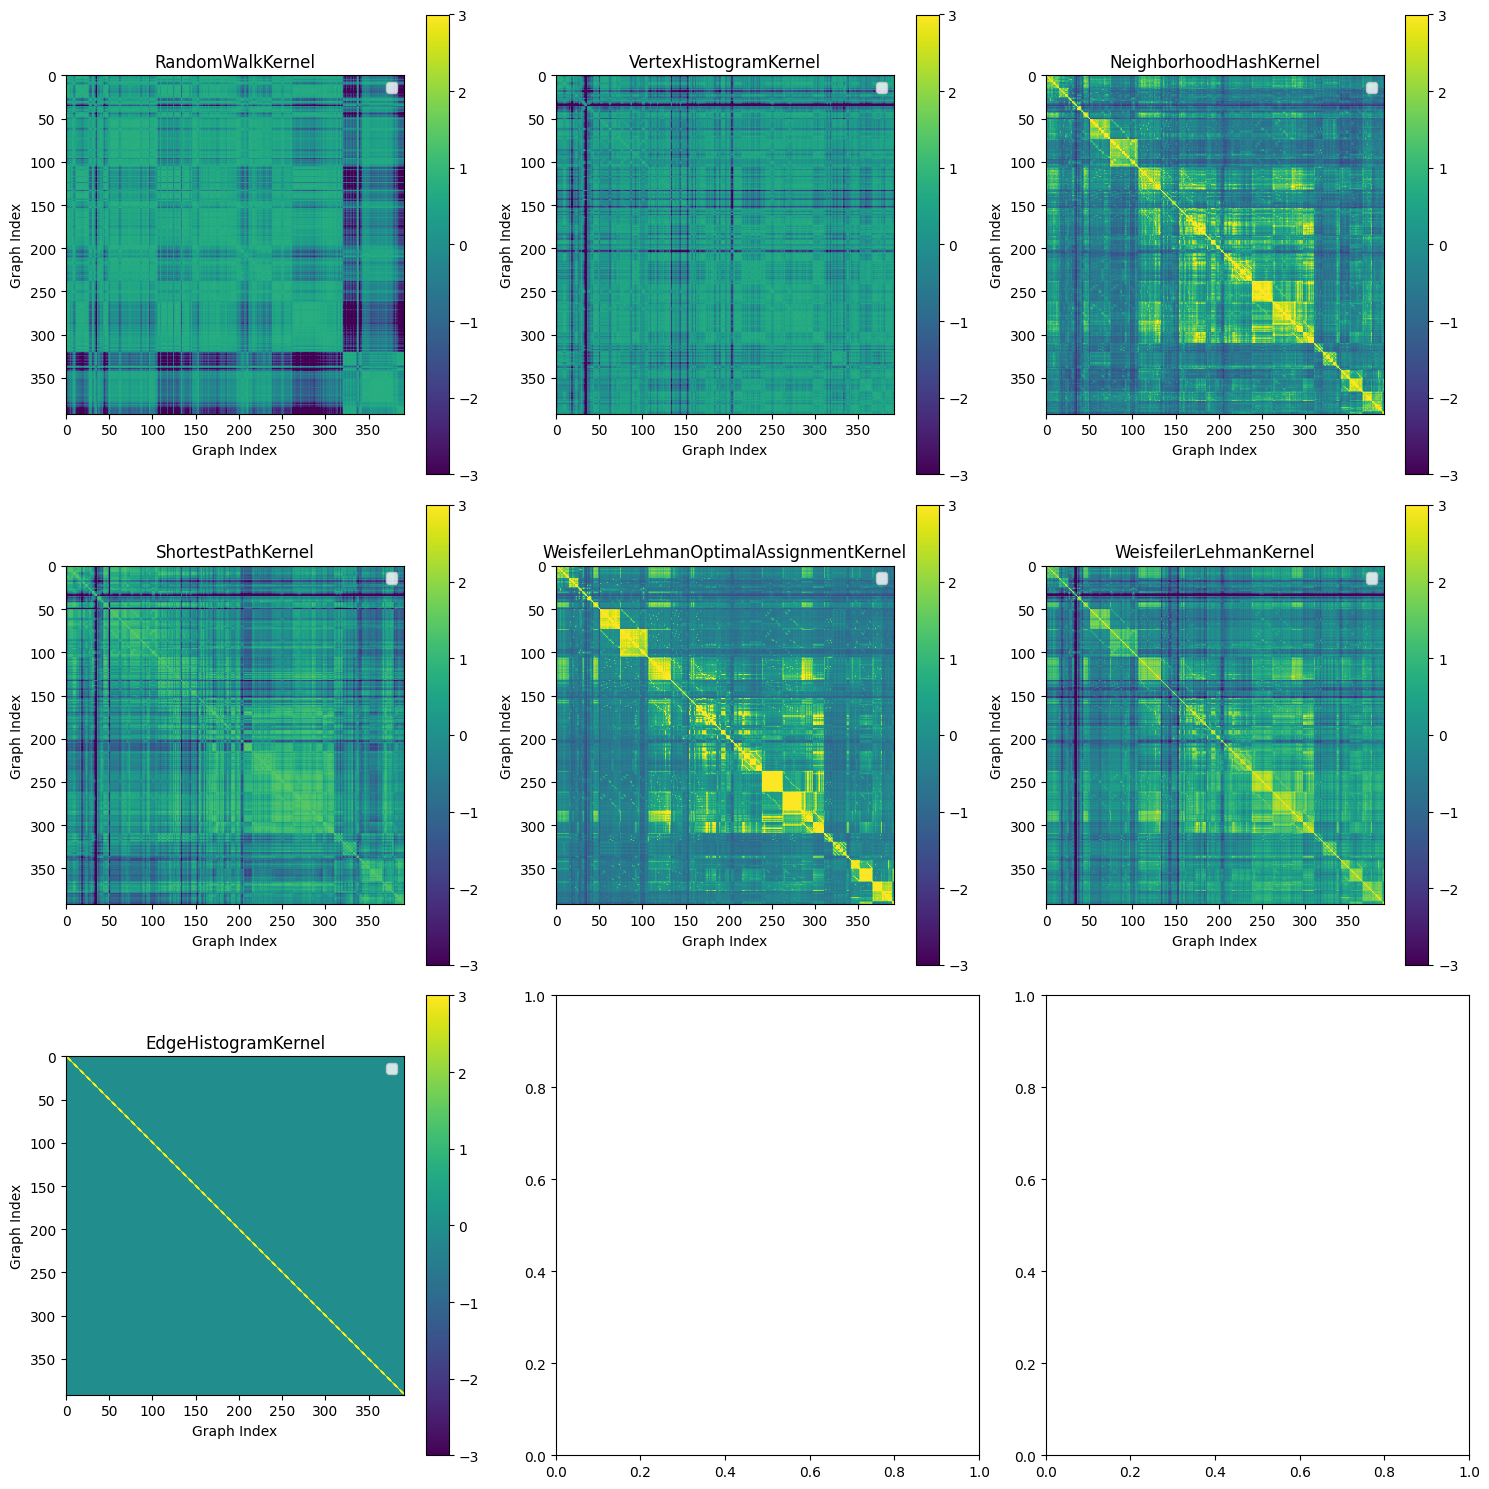

In [24]:
benchmark.generate_MSE()
benchmark.plot_MSE()
benchmark.plot_GP()
benchmark.generate_covariances()
benchmark.plot_label_differences()
benchmark.plot_covariances()